In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim import matutils
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import pickle
from pymongo import MongoClient
from bson import json_util

/home/cneiderer/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
%matplotlib inline
pyLDAvis.enable_notebook()
# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import pandas as pd
import numpy as np

import plotly
import json
credentials = json.load(open('/home/cneiderer/.plotly/.credentials'))
plotly.tools.set_credentials_file(username=credentials['username'], api_key=credentials['api_key'])

### Presidents List

In [4]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [5]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [6]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [7]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0)
df.index = range(0, df.shape[0])        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

### Clean Corpus

In [8]:
corpus = df['content']

In [9]:
len(corpus)

58595

In [10]:
# clean and stem presidential addresses
clean_corpus = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")
# house_senate_opening = re.compile('''to\s+the\s+(?:senate|house\s+of\s+representatives|)
#                                      (\s+and\s+)*(?:senate|house\s+of\s+representatives|house)*''')
for doc in corpus:
    temp = doc.lower()
    temp = re.sub(r'\n', ' ', temp)
    temp = re.sub(r'united\s+states', ' ', temp)
    temp = re.sub(r'mr.\s+(vice)?president', ' ', temp)
    temp = re.sub(r'(?:mr\.|madam)\s+speaker', ' ', temp)
    temp = re.sub(r'americaa', 'america', temp)
    temp = re.sub(r'special\s+message', ' ', temp)
    temp = re.sub(r'executive\s+order', ' ', temp)
    temp = re.sub(r'statement\s+on\s+the', ' ', temp)
    temp = re.sub(r'section\s+\d+', ' ', temp)
#     temp = re.sub(house_senate_opening, temp)
    temp = re.sub(r'[^A-Za-z]+', ' ', temp)
    temp = re.sub(punctuation, ' ', temp)
    
#     temp = word_tokenize(temp)
#     lemma = []
#     for word in temp:
#         lemma.append(stemmer.stem(word))
#     temp = ' '.join(clean_corpus[0])
    
    clean_corpus.append(temp)
    
len(clean_corpus)

58595

In [11]:
# Combine Sklearn and NLTK English stop words
months_list = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 
               'july', 'jul', 'august', 'aug', 'september', 'sept', 'october', 'oct', 'november', 'nov', 'december', 'dec']
custom_stopwords = ['hereunto', 'whereof', 'thereof', 'nineteen', 'said', 'herewith', 'shall', 'say', 'like',
                    'mr', 'mrs', 'sir', 'dear', 'george', 'bush', 'william', 'thirty', 'lot', 'want', 'let', 
                    'sure', 'way', 'section', 'act', 'answer', 'laughter', 'great', 'good', 'things', 'thing',
                    'going', 'know', 'day', 'new', 'make', 'got', 'yes', 'year', 'week', 'sec', 'obama', 'john'] + months_list

stopwords = sklearn_stopwords.ENGLISH_STOP_WORDS \
            .union(nltk_stopwords.words('english')) \
            .union(gensim_stopwords) \
            .union(custom_stopwords)

In [12]:
# Helper Function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [13]:
n_features = 1000
n_topics = 20
n_top_words = 20
seed = 129

In [14]:
# pickle TF-IDF NMF results
pickle_file = 'APP_tfidf_nmf_results.pickle'   
with open(pickle_file, 'rb') as f:
    data = pickle.load(f)
data.keys()    

dict_keys(['tfidf_vectorizer', 'tfidf', 'nmf', 'reduced'])

In [15]:
tfidf_vectorizer = data['tfidf_vectorizer']
tfidf = data['tfidf']
nmf = data['nmf']
reduced = data['reduced']

###  Normalize Topic Frequency by Year

In [16]:
tm_df = pd.DataFrame(reduced)

In [17]:
tm_df['year'] = df.document_date.dt.year

In [18]:
# Normalize topic frequency by year
topic_freq = tm_df.groupby('year').sum()
topic_freq = 100 * topic_freq.div(topic_freq.sum(axis=1), axis=0)
topic_freq = topic_freq.round(3)

In [19]:
topic_freq.sample(20, random_state=129)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
year,,,,,,,,,,,,,,,,,,,,
1873,1.679,7.552,7.167,16.071,1.458,6.335,17.657,1.280,2.116,4.329,8.667,2.334,0.654,5.204,1.399,10.120,4.634,0.884,0.397,0.063
1960,11.405,5.421,8.578,1.118,15.214,7.952,1.449,1.712,3.758,6.413,3.577,6.014,1.623,4.189,3.744,8.908,2.188,3.707,0.997,2.033
2015,11.338,4.937,8.304,0.428,5.244,3.895,0.497,10.913,3.799,4.064,5.223,1.618,7.508,2.038,7.647,4.194,2.191,2.535,5.093,8.532
1830,1.053,6.029,1.462,28.257,1.352,4.303,28.944,0.705,1.996,0.708,2.924,0.733,0.032,8.200,0.414,4.191,6.275,1.852,0.336,0.235
1968,11.636,6.794,6.857,2.181,8.470,7.132,1.283,1.561,2.959,5.336,3.134,3.116,4.383,3.496,6.094,8.970,4.663,4.373,0.975,6.585
1938,9.663,5.402,1.534,1.610,5.175,10.930,2.975,3.354,2.086,8.246,2.433,6.595,1.785,13.653,6.671,10.948,3.694,0.772,0.252,2.222
1983,9.194,4.457,10.932,2.293,10.188,5.189,1.232,2.868,5.024,5.313,2.163,2.143,3.460,1.912,8.679,7.728,4.093,5.049,2.526,5.559
1924,15.930,10.903,9.074,0.355,10.102,2.211,0.898,2.435,1.949,2.806,1.674,1.344,0.949,18.452,4.198,9.805,2.011,0.429,0.110,4.366
1915,11.751,12.963,8.338,0.834,9.018,4.192,2.020,1.616,3.810,6.901,3.356,2.161,0.305,24.961,1.774,3.001,2.041,0.373,0.127,0.457


### Plot Stacked Area Chart

In [20]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)

In [21]:
colors

,0,1,2,3
0,Red,#e6194b,"(230, 25, 75)","(0, 100, 66, 0)"
1,Green,#3cb44b,"(60, 180, 75)","(75, 0, 100, 0)"
2,Yellow,#ffe119,"(255, 225, 25)","(0, 25, 95, 0)"
3,Blue,#0082c8,"(0, 130, 200)","(100, 35, 0, 0)"
4,Orange,#f58231,"(245, 130, 48)","(0, 60, 92, 0)"
5,Purple,#911eb4,"(145, 30, 180)","(35, 70, 0, 0)"
6,Cyan,#46f0f0,"(70, 240, 240)","(70, 0, 0, 0)"
7,Magenta,#f032e6,"(240, 50, 230)","(0, 100, 0, 0)"
8,Lime,#d2f53c,"(210, 245, 60)","(35, 0, 100, 0)"
9,Pink,#fabebe,"(250, 190, 190)","(0, 30, 15, 0)"


In [22]:
cmap = list(colors[1])

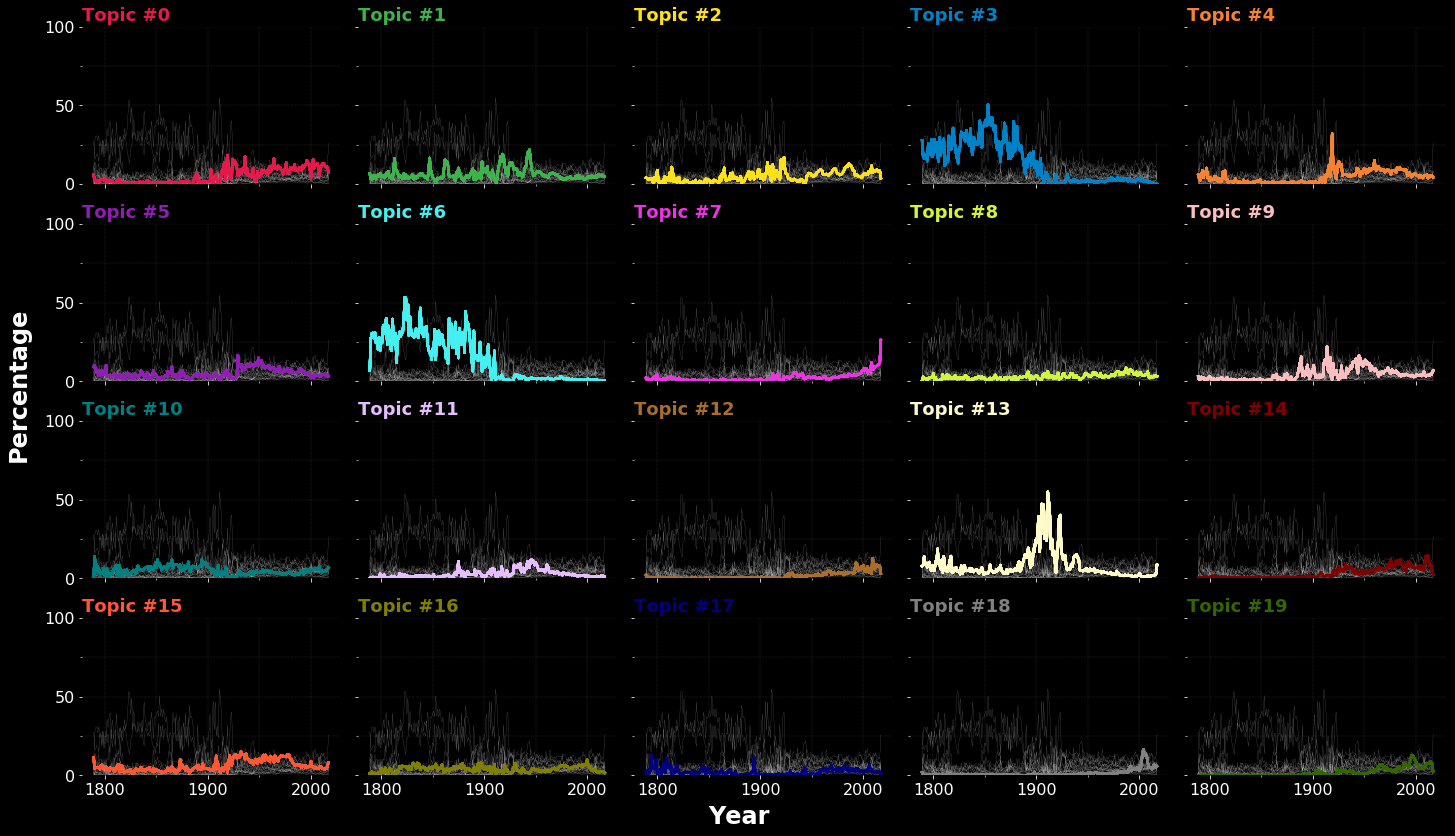

In [23]:
# plt.style.use('seaborn-darkgrid')
plt.style.use('dark_background')

# Initialize the figure
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for num, col in enumerate(topic_freq.columns):   
    # Get subplot axes
    ax = plt.subplot(4, 5, num+1)
    
    for col2 in topic_freq.columns:
        # plot every topic in background
        plt.plot(topic_freq.index, topic_freq[col2], 
                 marker='', color='white', linewidth=0.2, alpha=0.5)
        # highlight plot
        plt.plot(topic_freq.index, topic_freq[col], 
                 marker='', color=cmap[num], linewidth=2.4, alpha=1, label=col)
    
    # Set axes properties
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xticks([1850, 1950], minor=True)
    ax.set_xticks([1800, 1900, 2000], minor=False)
    ax.set_yticks([25, 75], minor=True)
    ax.set_yticks([0, 50, 100], minor=False)       
    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.grid(which='major', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.set_frame_on(0)
    
    ax.set_ylim(0, 100)    
    if num < 15:
        plt.tick_params(labelbottom='off')
    if num not in np.arange(0, 20, 5):
        plt.tick_params(labelleft='off')
    # Add title
    plt.title('Topic #%d' % col, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    
# general title and axis labels
# fig.suptitle('Topic Density Over Time', fontsize=36, fontweight='bold')
fig.text(0, 0.5, 'Percentage', 
         ha='center', va='center', rotation='vertical', 
         fontdict={'fontsize':24, 'fontweight':'bold'})
fig.text(0.5, 0, 'Year', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58595 entries, 0 to 58594
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 3.6+ MB


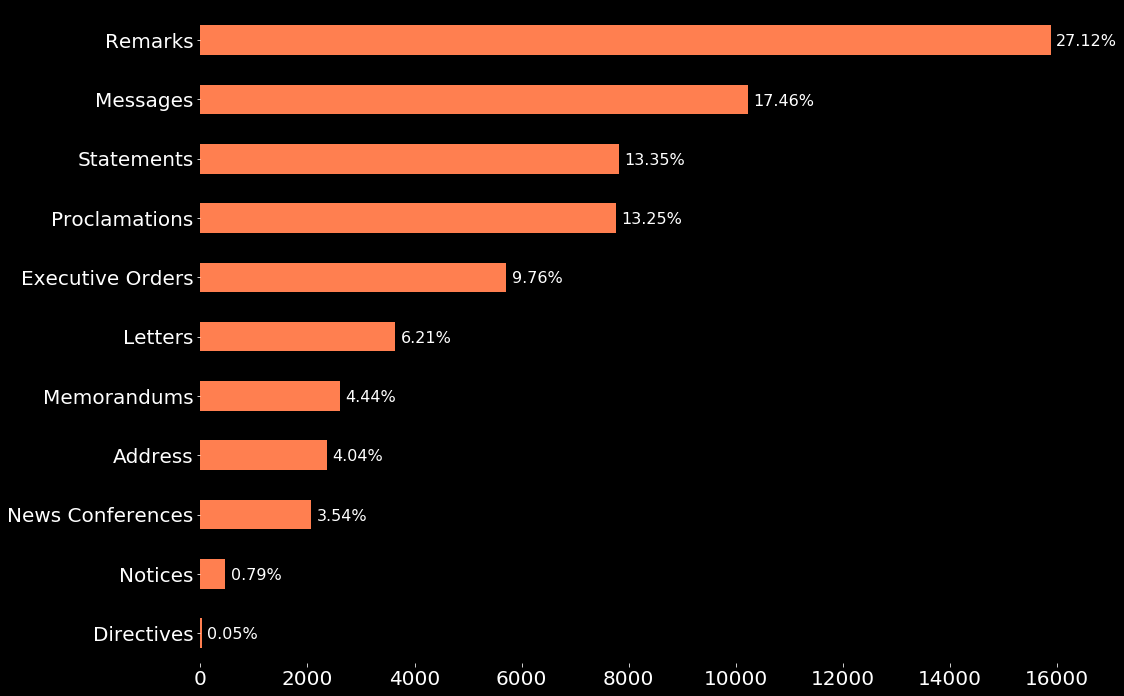

In [25]:
cats = df.category.value_counts(normalize=False, sort=True, ascending=True)
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16,12))
cats.plot(kind="barh", color='coral')
ax.set_frame_on(0)

# ax.set_title('Dataset Breakdown', fontdict={'fontsize': 20, 'fontweight': 'bold', 'fontstyle': 'italic'})
ax.tick_params(axis='both', labelsize=20)

# find the values and append to list
totals = []
for i in ax.patches:
    totals.append(i.get_width())
# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+100, i.get_y()+.15,
            str(round((i.get_width()/total)*100, 2))+'%', 
            color='white', fontsize=16)

### Clustering

In [26]:
agg = AgglomerativeClustering(n_clusters=20)

In [27]:
reduced.shape

(58595, 20)

In [28]:
agg.fit(reduced)

MemoryError: 